# 2D数据结构———以2维直线束为例

<span style="font-size: 20px; color: black;">本文展示astra的2D数据允许的函数操作以及如何进行内存管理</span>

# <span style="font-size: 30px; color: blue;">1. 导入工具包</span>
<span style="font-size: 20px; color: black;">python文件的第一步通常是引入所需要的包</span>

In [1]:
import astra
import numpy as np  #python主要的矩阵数据处理库
import pylab        #用于可视化

ModuleNotFoundError: No module named 'pylab'

# <span style="font-size: 30px; color: blue;">2. 确定几何</span>
<span style="font-size: 20px; color: black;">我们需要根据实际场景确定工程的几何参数设置.以下面图片展示的场景为例子</span>

![image.png](CT_par.png)

In [2]:
#体积参数
vol_geom = astra.create_vol_geom(256, 256)
#投影参数
proj_geom = astra.create_proj_geom(
    'parallel',    # 使用平行光束（如老式CT）
    1.0,           # 探测器间距1像素
    384,           # 有384个探测单元
    np.linspace(0, np.pi, 180, False)  # 从0到180°拍180张（每1° 1张），False表示不包含终点
)
#创建投影器
proj_id = astra.create_projector('cuda', proj_geom, vol_geom) 
# 'cuda'表示使用NVIDIA显卡加速

# <span style="font-size: 30px; color: blue;">3.创建数据对象</span>
<span style="font-size: 20px; color: black;">astra的2D数据存贮两种类型的数据，重建体和投影数据</span>

In [3]:
v0 = astra.data2d.create('-vol', vol_geom)          # 空容器（全0）
v1 = astra.data2d.create('-vol', vol_geom, 3.0)     # 所有格子填3.0
phantom_id, A = astra.data2d.shepp_logan(vol_geom)  # 生成标准测试模型
v2 = astra.data2d.create('-vol', vol_geom, A)       # 存入仿体数据
s0 = astra.data2d.create('-sino', proj_geom)

<span style="font-size: 20px; color: black;">可以根据ID使用get来获取array格式的数据</span>

In [4]:
R0 = astra.data2d.get(v0)
R1 = astra.data2d.get(v1)
R2 = astra.data2d.get(v2)
R0,R1,R2

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        ...,
        [3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [5]:
sino= astra.data2d.get(s0)
#查看np形状
sino.shape

(180, 384)

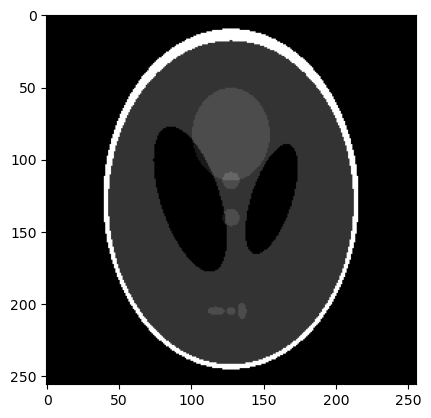

In [6]:
pylab.gray()  # 使用灰度图显示
pylab.imshow(R2) 

<span style="font-size: 20px; color: black;">改变获取的array变量不会影响astra对象</span>

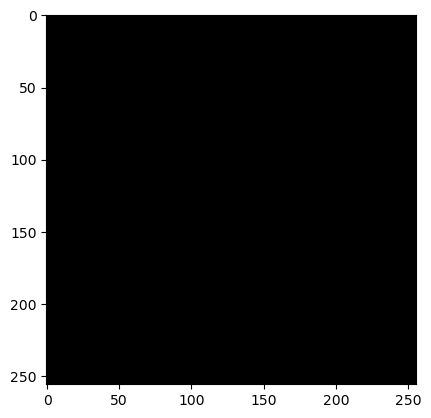

In [7]:
R0=R2.copy()
new_R0=astra.data2d.get(v0)
pylab.gray()  # 使用灰度图显示
pylab.imshow(new_R0) 

# <span style="font-size: 30px; color: blue;">4.编辑astra2D数据对象</span>
<span style="font-size: 20px; color: black;">我们可以根据实际场景利用ID编辑astra2D数据对象</span>

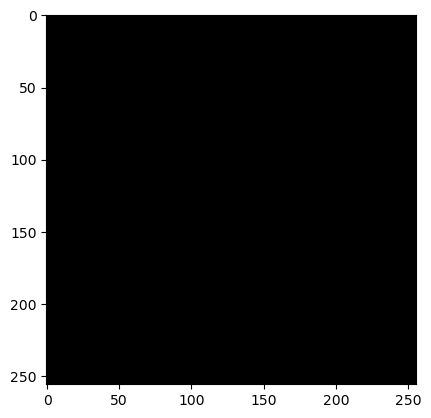

In [8]:
#写入常数
astra.data2d.store(v2, 0)
new_R2=astra.data2d.get(v2)
pylab.gray()  # 使用灰度图显示
pylab.imshow(new_R2) 

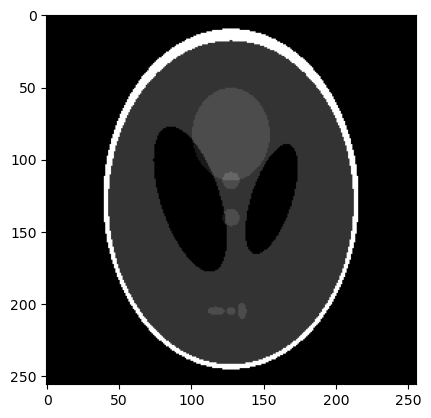

In [9]:
#写入矩阵
astra.data2d.store(v1, A)
new_R1=astra.data2d.get(v1)
pylab.gray()  # 使用灰度图显示
pylab.imshow(new_R1) 

# <span style="font-size: 30px; color: blue;">5. 其他操作</span>
<span style="font-size: 20px; color: black;">这里介绍一些2D数据允许的其他操作，下面的表列出了官方文档提供的函数</span>

| **函数类别** | **函数名称**           | **功能描述**                                                                 |
|--------------|-----------------------|--------------------------------------------------------------------------|
| **创建类**   | `create()`            | 创建新2D数据对象（体积/投影数据）                                          |
|              | `shepp_logan()`    | 生成标准/改进版Shepp-Logan仿体数据                                         |
|              | `link()`              | 将现有numpy数组与ASTRA内存关联（零拷贝）                                   |
| **存取类**   | `store()`          | 向现有对象填充数据（标量/数组）                                            |
|              | `get()`            | 获取数据副本（独立内存）                                                   |
|              | `get_shared()`     | 获取内存共享视图（修改会影响原始数据）                                      |
| **几何类**   | `get_geometry()`   | 获取对象的几何结构描述字典                                                 |
| **管理类**   | `delete()`         | 删除指定ID的对象                                                           |
|              | `clear()`           | 清空所有2D数据对象                                                         |
|              | `info()`           | 打印当前内存中所有2D对象信息                                               |

In [10]:
#info
astra.data2d.info()

id  init  description
-----------------------------------------
2 	v     256x256 volume data 	
3 	v     256x256 volume data 	
4 	v     256x256 volume data 	
5 	v     256x256 volume data 	
6 	v     384x180 sinogram data 	
-----------------------------------------



In [11]:
astra.data2d.clear()
astra.data2d.info()

id  init  description
-----------------------------------------
-----------------------------------------



<span style="font-size: 20px; color: black;">link函数将array映射为astra数据对象</span>

In [12]:
external_array = np.zeros((256, 256), dtype=np.float32)
mapped_id = astra.data2d.link('-vol', vol_geom, external_array)
# 此时修改external_array会同步影响ASTRA内部数据！
external_array[100:150, 100:150] = 1.0  # 直接生效
astra.data2d.info()

id  init  description
-----------------------------------------
7 	v     256x256 volume data 	
-----------------------------------------



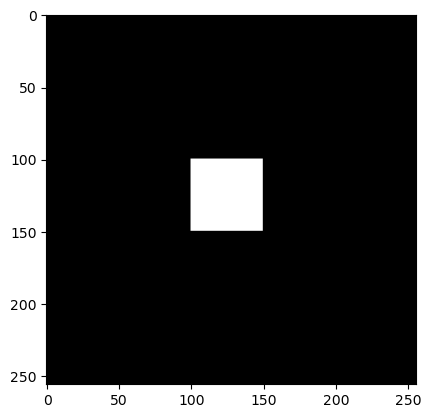

In [13]:
change_R=astra.data2d.get(mapped_id)
pylab.gray()  # 使用灰度图显示
pylab.imshow(change_R) 

<span style="font-size: 20px; color: black;">利用 get_geometry()获取对象的几何结构描述字典</span>

In [14]:
geom = astra.data2d.get_geometry(mapped_id)
print(geom)  # 输出几何结构详情

{'GridColCount': 256, 'GridRowCount': 256, 'options': {'WindowMinX': -128, 'WindowMaxX': 128, 'WindowMinY': -128, 'WindowMaxY': 128}}


<span style="font-size: 20px; color: black;">在生成数据时可以选择不返回具体内容</span>

In [15]:
# 标准仿体
std_phantom_id, std_data = astra.data2d.shepp_logan(vol_geom)
# 修改版仿体（对比度高）
modified_phantom_id = astra.data2d.shepp_logan(vol_geom, modified=True, returnData=False)
astra.data2d.info()

id  init  description
-----------------------------------------
7 	v     256x256 volume data 	
8 	v     256x256 volume data 	
9 	v     256x256 volume data 	
-----------------------------------------



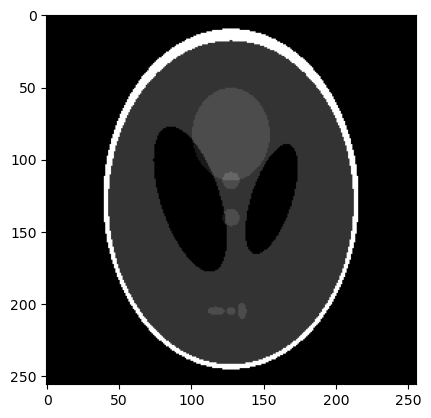

In [16]:
mp=astra.data2d.get_shared(modified_phantom_id)
pylab.gray()  # 使用灰度图显示
pylab.imshow(mp) 

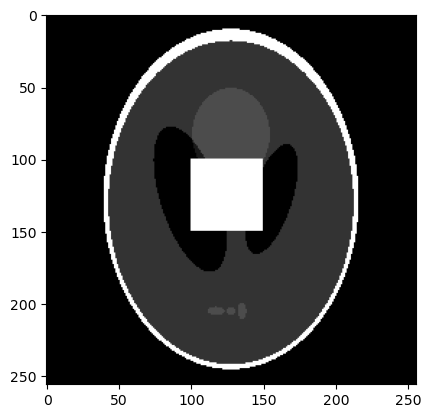

In [17]:
mp[100:150, 100:150] = 1.0  # 直接生效
new_mp=astra.data2d.get(modified_phantom_id)
pylab.gray()  # 使用灰度图显示
pylab.imshow(new_mp) 

In [18]:
astra.data2d.clear()